In [2]:
#アーキテクチャに沿って分類する
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.feature import hog
from PIL import Image
from skimage import io
from skimage import feature
import math
import glob
import re

In [3]:
#形状
# シイタケ画像に円を当てはめて一致率を判定
folder_lists = [
    "/home/data/test/mask"
]
opname = "jikken"

# 真円フィッティングを行うかどうかのフラグ
fit_circle = True # Trueなら真円、Falseなら楕円
jusin = False

for folder_path in folder_lists:
    folder_name = folder_path.split("/")[-1]
    output_file = f'/home/src/round_attach_result/{opname}_result.txt'
    img_files = glob.glob(os.path.join(folder_path, '*.jpg'))
    results = [f"Folder: {folder_name}\n"]
    
    for img_file in img_files:
        # print(f"Processing {img_file}")
        mask_img  = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
        _, mask_img = cv2.threshold(mask_img, 128, 255, cv2.THRESH_BINARY)
        counters, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if counters:
            max_counter = max(counters, key=cv2.contourArea)
        
        if fit_circle and not jusin:#真円
            (x,y), radius = cv2.minEnclosingCircle(max_counter)
            center = (int(x), int(y))
            radius = int(radius)
            shape_mask = np.zeros_like(mask_img)
            cv2.circle(shape_mask, center, radius, 255, -1)
        
        if fit_circle and jusin:#真円＋重心
                (x, y), radius = cv2.minEnclosingCircle(max_counter)
                # 重心を計算する            
                M = cv2.moments(max_counter)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                else:
                    cX, cY = 0, 0
                center = (cX, cY)
                radius = int(radius)
                shape_mask = np.zeros_like(mask_img)
                cv2.circle(shape_mask, center, radius, 255, -1)
        
        intersection = cv2.bitwise_and(mask_img, shape_mask)
        union = cv2.bitwise_or(mask_img, shape_mask)
        intersection_area = np.sum(intersection == 255)
        union_area = np.sum(union == 255)
        iou = intersection_area / union_area
        
        if fit_circle:
            results.append(f"File: {os.path.basename(img_file)}, Center: {center}, Radius: {radius}, IoU: {iou:.2f}")
            # print(iou)
            if iou >= 0.89:
                results.append(f" Result: AB\n")
            else:
                results.append(f" Result: CD\n")
    with open(output_file, 'w') as f:
        f.writelines(results)    

In [4]:
# サイズ
for folder_path in folder_lists:
    folder_name = folder_path.split("/")[-1]
    img_files = glob.glob(os.path.join(folder_path, '*.jpg'))
    
    for img_file in img_files:
        # print(f"Processing {img_file}")
        mask_img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
        _, mask_img = cv2.threshold(mask_img, 128, 255, cv2.THRESH_BINARY)
        count_255 = np.sum(mask_img == 255)
        total_pixels = mask_img.size
        percentage_255 = (count_255 / total_pixels) * 100
        cm2 = 5184
        mask_cm2 = count_255 / cm2
        
        with open("/home/src/round_attach_result/jikken.txt", 'a') as f:
            f.write(f"{os.path.basename(img_file)} : {mask_cm2:.2f} cm^2")
            if mask_cm2 >= 20:
                f.write(" Result: AB\n")
            else:
                f.write(" Result: CD\n")

In [5]:
import os
import re
import cv2
import numpy as np
import math
from PIL import Image

# 画像が保存されているフォルダのパス
path = '/home/data/1008/crop'
output_path = '/home/data/1008/hida'
output_path_maxfil = '/home/data/1008/hida_maxfil'
txtfile = "/home/src/round_attach_result/jikken_result.txt"

# txtファイルから中心座標を読み取る関数
def read_center_coordinates(txtfile):
    center = {}
    with open(txtfile, 'r') as file:
        for line in file:
            if line.startswith("File:"):
                parts = line.split(',')
                img_name = parts[0].split(':')[1].strip()
                
                # 正規表現でCenterの座標を抽出する
                match = re.search(r'Center:\s*\((\d+),\s*(\d+)\)', line)
                if match:
                    x, y = map(int, match.groups())
                    img_key = img_name.split('.')[0]
                    center[img_key] = (x, y)
    return center

# 画像を処理する関数
def process_image(img_path, filename, out_path, out_max_path, center_coordinates):
    img = cv2.imread(img_path)[:,:,::-1]
    img_name_with_extension = os.path.basename(img_path)
    img_name, _ = os.path.splitext(img_name_with_extension)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 中心からのベクトル
    height, width = img.shape
    x_coords = np.zeros(height, dtype=int)
    y_coords = np.arange(height)
    coords_y = list(zip(x_coords, y_coords))
    x_coords = np.arange(width)
    y_coords = np.zeros(width, dtype=int)
    coords_x = list(zip(x_coords, y_coords))
    coords = coords_x + coords_y
    x_elements = [x for x, y in coords]
    y_elements = [y for x, y in coords]
    
    filtersize = 4
    stride = 1
    img = img.astype(np.int16)
    filtered_img1 = np.zeros((filtersize, filtersize))
    filtered_img2 = np.zeros((filtersize, filtersize))
    nvector = np.zeros((math.floor((img.shape[0] - filtersize) / stride + 1), math.floor((img.shape[1] - filtersize) / stride + 1), 2))
    x_fill = 0
    y_fill = 0
    for g in range(0, (math.floor((img.shape[0] - filtersize) / stride + 1)), 1):
        for h in range(0, (math.floor((img.shape[1] - filtersize) / stride + 1)), 1):
            for i in range(0, filtersize-1, 1):
                for j in range(0, filtersize-1, 1):
                    filtered_img1[i, j] = img[y_fill + i, x_fill + j] - img[y_fill + i+1, x_fill + j+1]
                    filtered_img2[i, j] = img[y_fill + i+1, x_fill + j] - img[y_fill + i, x_fill + j+1]
            vector1 = np.max(filtered_img1)
            vector2 = np.max(filtered_img2)
            nvector[g, h] = (vector1, vector2)
            x_fill += stride
        y_fill += stride
        x_fill = 0
    
    threshold = 50
    for i in range(nvector.shape[0]):
        for j in range(nvector.shape[1]):
            if np.sqrt(nvector[i][j][0]**2 + nvector[i][j][1]**2) < threshold:
                nvector[i][j] = (1111, 1111)
    
    if img_name in center_coordinates:
        center_coordinates = center_coordinates[img_name]
        center_vector_x = np.zeros((img.shape[1]) + (img.shape[0]))
        center_vector_y = np.zeros((img.shape[1]) + (img.shape[0]))
        for i in range((img.shape[1]) + (img.shape[0])):
            center_vector_x[i] = x_elements[i] - center_coordinates[0]
            center_vector_y[i] = y_elements[i] - center_coordinates[1]
        center_vector = np.array(list(zip(center_vector_x.flatten(), center_vector_y.flatten())))
    
        img_vector = np.zeros((nvector.shape[0], nvector.shape[1]))
        img_vector_min = np.zeros(center_vector.shape[0])
        for i in range(nvector.shape[0]):
            for j in range(nvector.shape[1]):
                for k in range(center_vector.shape[0]):
                    if (nvector[i, j][0] == 1111) and (nvector[i, j][1] == 1111):
                        img_vector_min[k] = 1111
                    else:
                        img_vector_min[k] = np.dot(nvector[i, j], center_vector[k])
                img_vector[i, j] = np.min(abs(img_vector_min))
    
        img_vector2 = img_vector
        threshold = 0.2
        for i in range(nvector.shape[0]-1, 0, -1):
            for j in range(nvector.shape[1]-1, 0, -1):
                if img_vector[i, j] < threshold:
                    img_vector2[i, j] = 1
                else:
                    img_vector2[i, j] = 0
    
        new_img = np.zeros((img.shape[0], img.shape[1]))
        for g in range(img_vector2.shape[0]):
            for h in range(img_vector2.shape[1]):
                if img_vector2[g, h] == 1:
                    for i in range(filtersize):
                        for j in range(filtersize):
                            if i+h*stride < img.shape[0] and j+g*stride < img.shape[1]:
                                new_img[i + h*stride, j + g*stride] = 255
                else:
                    for i in range(filtersize):
                        for j in range(filtersize):
                            if i+h*stride < img.shape[0] and j+g*stride < img.shape[1]:
                                new_img[i + h*stride, j + g*stride] = 0
    
        next_img = Image.fromarray(new_img)
        next_img = next_img.convert('L')
        output_file_path = os.path.join(out_path, filename)
        next_img.save(output_file_path)
    
        kernel = np.ones((5, 5), np.uint8)
        dilated_img = cv2.dilate(new_img, kernel, iterations=1)
        output_file_path_maxfil = os.path.join(out_max_path, filename)
        cv2.imwrite(output_file_path_maxfil, dilated_img)

# 中心座標を読み取る
center_coordinates = read_center_coordinates(txtfile)

# フォルダ内のすべてのファイルを一覧
for root, dirs, files in os.walk(path):
    for filename in files:
        file_path = os.path.join(root, filename)
        out_path = os.path.join(output_path, os.path.relpath(root, path))
        out_max_path = os.path.join(output_path_maxfil, os.path.relpath(root, path))
        os.makedirs(out_path, exist_ok=True)
        os.makedirs(out_max_path, exist_ok=True)
        process_image(file_path, filename, out_path, out_max_path, center_coordinates)

In [6]:
#test
import os
import re
import cv2
import numpy as np
import math
from PIL import Image

# 画像が保存されているフォルダのパス
path = '/home/data/test/crop'
output_path = '/home/data/test/hida'
output_path_maxfil = '/home/data/test/hida_maxfil'
mask_path = '/home/data/test/mask'
mask_min_path = '/home/data/test/mask_min'
txtfile = "/home/src/round_attach_result/jikken_result.txt"

# txtファイルから中心座標を読み取る関数
def read_center_coordinates(txtfile):
    center = {}
    with open(txtfile, 'r') as file:
        for line in file:
            if line.startswith("File:"):
                parts = line.split(',')
                img_name = parts[0].split(':')[1].strip()
                match = re.search(r'Center:\s*\((\d+),\s*(\d+)\)', line)
                if match:
                    x, y = map(int, match.groups())
                    img_key = img_name.split('.')[0]
                    center[img_key] = (x, y)
    return center

# 画像を処理する関数
def process_image(img_path, filename, out_path, out_max_path, center_coordinates):
    img = cv2.imread(img_path)[:,:,::-1]
    img_name_with_extension = os.path.basename(img_path)
    img_name, _ = os.path.splitext(img_name_with_extension)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 中心からのベクトル
    height, width = img.shape
    x_coords = np.zeros(height, dtype=int)
    y_coords = np.arange(height)
    coords_y = list(zip(x_coords, y_coords))
    x_coords = np.arange(width)
    y_coords = np.zeros(width, dtype=int)
    coords_x = list(zip(x_coords, y_coords))
    coords = coords_x + coords_y
    x_elements = [x for x, y in coords]
    y_elements = [y for x, y in coords]
    
    filtersize = 4
    stride = 1
    img = img.astype(np.int16)
    filtered_img1 = np.zeros((filtersize, filtersize))
    filtered_img2 = np.zeros((filtersize, filtersize))
    nvector = np.zeros((math.floor((img.shape[0] - filtersize) / stride + 1), math.floor((img.shape[1] - filtersize) / stride + 1), 2))
    x_fill = 0
    y_fill = 0
    for g in range(0, (math.floor((img.shape[0] - filtersize) / stride + 1)), 1):
        for h in range(0, (math.floor((img.shape[1] - filtersize) / stride + 1)), 1):
            for i in range(0, filtersize-1, 1):
                for j in range(0, filtersize-1, 1):
                    filtered_img1[i, j] = img[y_fill + i, x_fill + j] - img[y_fill + i+1, x_fill + j+1]
                    filtered_img2[i, j] = img[y_fill + i+1, x_fill + j] - img[y_fill + i, x_fill + j+1]
            vector1 = np.max(filtered_img1)
            vector2 = np.max(filtered_img2)
            nvector[g, h] = (vector1, vector2)
            x_fill += stride
        y_fill += stride
        x_fill = 0
    
    threshold = 50
    for i in range(nvector.shape[0]):
        for j in range(nvector.shape[1]):
            if np.sqrt(nvector[i][j][0]**2 + nvector[i][j][1]**2) < threshold:
                nvector[i][j] = (1111, 1111)
    
    if img_name in center_coordinates:
        center_coordinates = center_coordinates[img_name]
        center_vector_x = np.zeros((img.shape[1]) + (img.shape[0]))
        center_vector_y = np.zeros((img.shape[1]) + (img.shape[0]))
        for i in range((img.shape[1]) + (img.shape[0])):
            center_vector_x[i] = x_elements[i] - center_coordinates[0]
            center_vector_y[i] = y_elements[i] - center_coordinates[1]
        center_vector = np.array(list(zip(center_vector_x.flatten(), center_vector_y.flatten())))
    
        img_vector = np.zeros((nvector.shape[0], nvector.shape[1]))
        img_vector_min = np.zeros(center_vector.shape[0])
        for i in range(nvector.shape[0]):
            for j in range(nvector.shape[1]):
                for k in range(center_vector.shape[0]):
                    if (nvector[i, j][0] == 1111) and (nvector[i, j][1] == 1111):
                        img_vector_min[k] = 1111
                    else:
                        img_vector_min[k] = np.dot(nvector[i, j], center_vector[k])
                img_vector[i, j] = np.min(abs(img_vector_min))
    
        img_vector2 = img_vector
        threshold = 0.2
        for i in range(nvector.shape[0]-1, 0, -1):
            for j in range(nvector.shape[1]-1, 0, -1):
                if img_vector[i, j] < threshold:
                    img_vector2[i, j] = 1
                else:
                    img_vector2[i, j] = 0
        new_img = np.zeros((img.shape[0], img.shape[1]))
        for g in range(img_vector2.shape[0]):
            for h in range(img_vector2.shape[1]):
                if img_vector2[g, h] == 1:
                    for i in range(filtersize):
                        for j in range(filtersize):
                            if i+h*stride < img.shape[0] and j+g*stride < img.shape[1]:
                                new_img[i + h*stride, j + g*stride] = 255
                else:
                    for i in range(filtersize):
                        for j in range(filtersize):
                            if i+h*stride < img.shape[0] and j+g*stride < img.shape[1]:
                                new_img[i + h*stride, j + g*stride] = 0
    
        next_img = Image.fromarray(new_img)
        next_img = next_img.convert('L')
        #マスク画像と掛け算
        mask_min_img = Image.open(f"{mask_min_path}/{filename}").convert('L')
        mask_min_array = np.array(mask_min_img)
        next_img_array = np.array(next_img)
        next_img_array[mask_min_array == 0] = 0
        next_img = Image.fromarray(next_img_array)
    
        output_file_path = os.path.join(out_path, filename)
        next_img.save(output_file_path)
    
        kernel = np.ones((5, 5), np.uint8)
        dilated_img = cv2.dilate(new_img, kernel, iterations=1)
        output_file_path_maxfil = os.path.join(out_max_path, filename)
        cv2.imwrite(output_file_path_maxfil, dilated_img)

# 中心座標を読み取る
center_coordinates = read_center_coordinates(txtfile)

# フォルダ内のすべてのファイルを一覧
for root, dirs, files in os.walk(path):
    for filename in files:
        file_path = os.path.join(root, filename)
        out_path = os.path.join(output_path, os.path.relpath(root, path))
        out_max_path = os.path.join(output_path_maxfil, os.path.relpath(root, path))
        os.makedirs(out_path, exist_ok=True)
        os.makedirs(out_max_path, exist_ok=True)
        process_image(file_path, filename, out_path, out_max_path, center_coordinates)

In [7]:
#mask画像を一回り小さくしたものを作る
#for文で0→255,255→0を見つけてそこから指定分0にする
import os
import cv2
import numpy as np
from PIL import Image

# マスク画像のパス
mask_path = '/home/data/test/mask'
output_path = '/home/data/test/mask_min'

number = 10

for dirname, _, files in os.walk(mask_path):
    for file in files:
        file_path = os.path.join(dirname, file)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
        img_output = img.copy()
        h, w = img.shape
        
        # 横方向の処理
        for i in range(h):
            for j in range(w):
                if img[i, j] == 255:
                    if j > 0 and img[i, j-1] == 0 and j <= number:
                        for k in range(number):
                            if j + k < w:
                                img_output[i, j + k] = 0
                    elif j > 0 and img[i, j-1] == 0 and j > number:
                        for k in range(number):
                            if j + k < w:
                                img_output[i, j + k] = 0
                    elif j == w-1:
                        for k in range(number):
                            if j - k >= 0:
                                img_output[i, j - k] = 0
                    elif j < w-1 and img[i, j+1] == 0:
                        for k in range(number):
                            if j - k >= 0:
                                img_output[i, j - k] = 0
        
        # 縦方向の処理
        for j in range(w):
            for i in range(h):
                if img[i, j] == 255:
                    if i > 0 and img[i-1, j] == 0 and i <= number:
                        for k in range(number):
                            if i + k < h:
                                img_output[i + k, j] = 0
                    elif i > 0 and img[i-1, j] == 0 and i > number:
                        for k in range(number):
                            if i + k < h:
                                img_output[i + k, j] = 0
                    elif i == h-1:
                        for k in range(number):
                            if i - k >= 0:
                                img_output[i - k, j] = 0
                    elif i < h-1 and img[i+1, j] == 0:
                        for k in range(number):
                            if i - k >= 0:
                                img_output[i - k, j] = 0
        
        output_file_path = os.path.join(output_path, file)
        os.makedirs(output_path, exist_ok=True)
        cv2.imwrite(output_file_path, img_output)

In [3]:
import os
import re
import cv2
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from icecream import ic

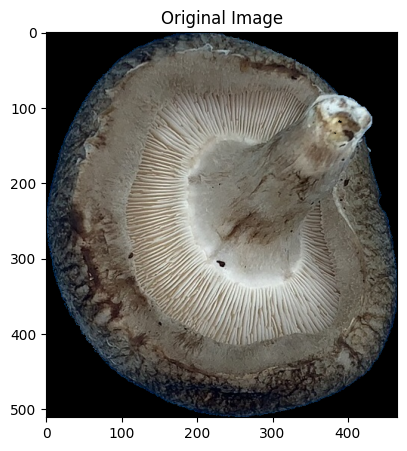

In [4]:
#論文の再現

# img_path = '/home/data/1216/cropBB/B/IMG_1745.JPEG'
# img_path = '/home/data/1216_jikunashi/cropBB/A/IMG_1834.JPEG'
# img_path = '/home/data/1216_jikunashi/cropBB/C/IMG_1699.JPEG'
# img_path = '/home/data/0108_size/cropBB/B/IMG_1703.JPEG'
img_path = '/home/data/0108_jikunashi_energee/cropBB/B/IMG_1703.JPEG'
# img_path = "/home/data/1008/crop/IMG_0003.png"
# img_path = "/home/data/1008/crop/resized_image.png"

# 画像の読み込み
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 画像をHSV色空間に変換
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# 青色の範囲を定義
lower_blue = np.array([20, 100, 100])
upper_blue = np.array([255, 255, 255])
# 青色のマスクを作成
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# マスクの反転（前景を白、背景を黒にする）
mask_img = cv2.bitwise_not(mask)
_,mask_img = cv2.threshold(mask_img, 128, 255, cv2.THRESH_BINARY)

masked_img = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_img)

# 結果を表示
plt.figure(figsize=(5, 5))
plt.title('Original Image')
plt.imshow(masked_img)
plt.show()


In [47]:
# fig, axes = plt.subplots(1, 2, figsize=(7, 7))
# axes[0].imshow(f0xy, )  # カラーマップを'hot'に変更
# axes[1].imshow(C0xy, )  # カラーマップを'hot'に変更
# axes[0].set_title('f0xy')
# axes[1].set_title('C0xy')
# plt.show()

# print(np.max(f0xy), np.min(f0xy))
# print(np.max(C0xy), np.min(C0xy))

In [48]:
# # plt.imshow(img, cmap='gray')
# # print(img)
# #np.gradient = 片側，もしくは両側の差を計算する(1,3,4)の場合(2,1.5,1)
# fdy,fdx = np.gradient(image)
# # print(fdx)

# absfxy = np.sqrt(fdx**2 + fdy**2)
# print(absfxy)

In [5]:
#重心(1)
img = cv2.imread(img_path)

# 画像のサイズを取得
h, w = img.shape[:2]

# 重心を求めるための変数を初期化
x_sum, y_sum = 0, 0
count = 0

# マスク画像の白いピクセルの座標を合計
for i in range(h):
    for j in range(w):
        if mask_img[i][j] == 255:
            x_sum += j
            y_sum += i
            count += 1

# 白いピクセルの数で割って重心を求める
if count > 0:
    xc = x_sum / count
    yc = y_sum / count
else:
    xc, yc = 0, 0  # 白いピクセルがない場合

# ic(f"重心の座標: ({xc}, {yc})")

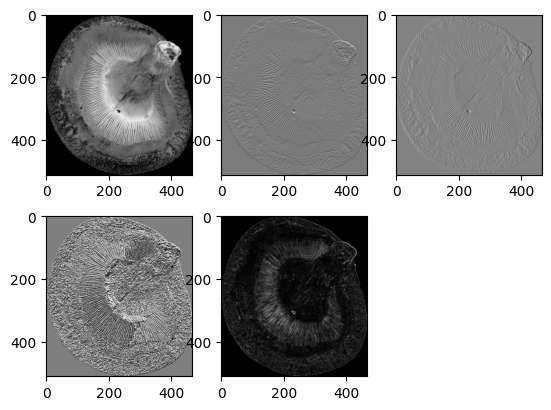

In [14]:
#fθ(x,y)(勾配の方向),|f(x,y)|    (2)(3)
image = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
fdy,fdx = np.gradient(image)
# fdy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
# fdx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
f0xy = np.arctan2(fdy,fdx)
# f0xy = np.arctan2(fdx,fdy)
absfxy = np.uint8(np.sqrt(fdx**2 + fdy**2))
# ic(fdy)
# ic(f0xy)
# ic(absfxy)
# print(image

plt.subplot(2, 3, 1)
plt.imshow(image,cmap = "gray")
plt.subplot(2, 3, 2)
plt.imshow(fdy,cmap = "gray")
plt.subplot(2, 3, 3)
plt.imshow(fdx, cmap = "gray")
plt.subplot(2, 3, 4)
plt.imshow(f0xy, cmap = "gray")
plt.subplot(2, 3, 5)
plt.imshow(absfxy, cmap = "gray")
plt.show()

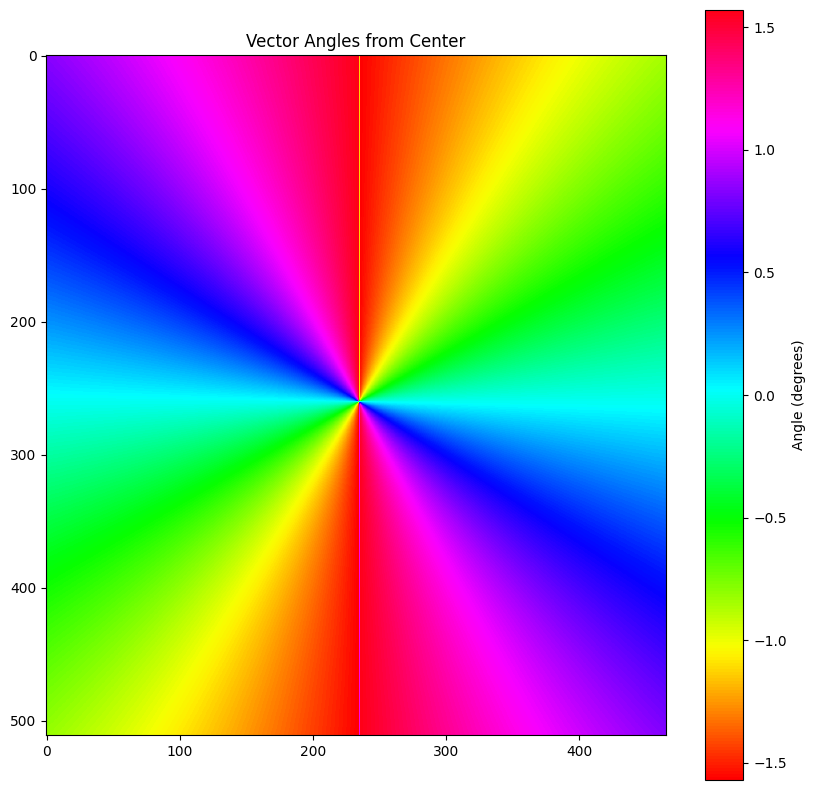

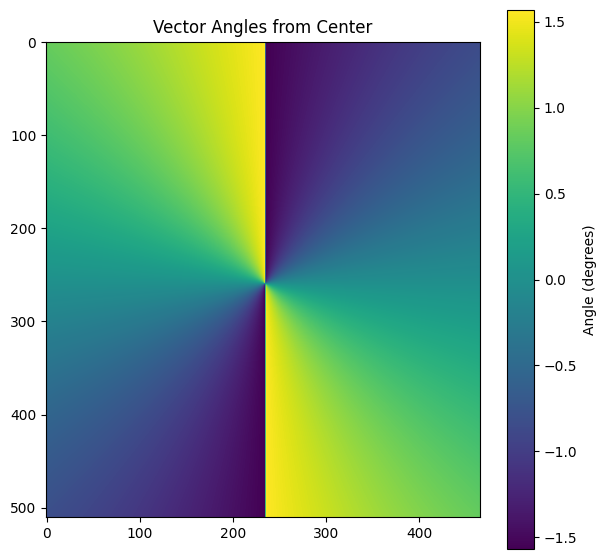

In [9]:
#C0(x,y)：中心からのベクトルの角度
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 画像のサイズを取得
height, width = image.shape
# ベクトルの角度を格納する配列を初期化
C0xy = np.zeros((height, width))

# すべての点でベクトルの角度を計算
for y in range(height):
    for x in range(width):
        dx = x - xc
        dy = y - yc
        # C0xy[y, x] = np.arctan2(dy,dx)
        C0xy[y, x] = np.arctan(dy/dx)
        # C0xy[y, x] = dy + dx
# ic((C0xy))
# # 結果を表示
plt.figure(figsize=(10, 10))
plt.imshow(C0xy, cmap='hsv')
plt.colorbar(label='Angle (degrees)')
plt.title('Vector Angles from Center')
plt.show()
plt.figure(figsize=(7, 7))
plt.imshow(C0xy, )  # カラーマップを'hot'に変更
plt.colorbar(label='Angle (degrees)')
plt.title('Vector Angles from Center')
plt.show()

In [52]:
# fig, axes = plt.subplots(1, 2, figsize=(7, 7))
# axes[0].imshow(f0xy, )  # カラーマップを'hot'に変更
# axes[1].imshow(C0xy, )  # カラーマップを'hot'に変更
# axes[0].set_title('f0xy')
# axes[1].set_title('C0xy')
# plt.show()

# print(np.max(f0xy), np.min(f0xy))
# print(np.max(C0xy), np.min(C0xy))

In [8]:
def Min(a, b):
    return np.minimum(a, b)

In [10]:
def G12(theta1, theta2):
    """
    角度 theta1 と theta2 の差を条件に基づいて計算する関数。
    
    Args:
    theta1 (float): 角度1
    theta2 (float): 角度2
    
    Returns:
    float: 計算された差
    """
    # 条件1: θ2 - π < θ1 < θ2, 0 <= θ2
    condition1 = (theta2 - np.pi < theta1) & (theta1 < theta2) & (theta2 >= 0)
    result1 = np.abs(theta1 - theta2)


    # 条件2: -π < θ1 < θ2 - π, 0 <= θ2
    condition2 = (-np.pi < theta1) & (theta1 < (theta2 - np.pi)) & (theta2 >= 0)
    result2 = theta2 - 2 * np.pi - theta1

    # 条件3: -π < θ1 < θ2 + π, θ2 < 0
    condition3 = (-np.pi < theta1) & (theta1 < (theta2 + np.pi)) & (theta2 < 0)
    # condition3 = (-np.pi-np.pi/2 < theta1) & (theta1 < (theta2 + np.pi)) & (theta2 < 0)
    result3 = np.abs(theta1 - theta2)

    # 条件4: θ2 + π < θ1 < π, θ2 < 0
    condition4 = (theta2 + np.pi < theta1) & (theta1 < np.pi) & (theta2 < 0)
    # condition4 = (theta2 + np.pi < theta1) & (theta1 < np.pi+np.pi/2) & (theta2 < 0)
    result4 = theta1 - theta2 - 2 * np.pi

    # 条件に基づいて結果を選択
    result = np.where(condition1, result1, 
             np.where(condition2, result2, 
             np.where(condition3, result3, 
             np.where(condition4, result4, 0))))
    # result = np.where(condition1, 1, 
    #          np.where(condition2, 2, 
    #          np.where(condition3, 3, 
    #          np.where(condition4, 4, 0))))
    # result = np.where(condition1, 1, 0)
    # result = np.where(condition2, 2, 0)
    # result = np.where(condition3, 3, 0)
    # result = np.where(condition4, 4, 0)

    return result

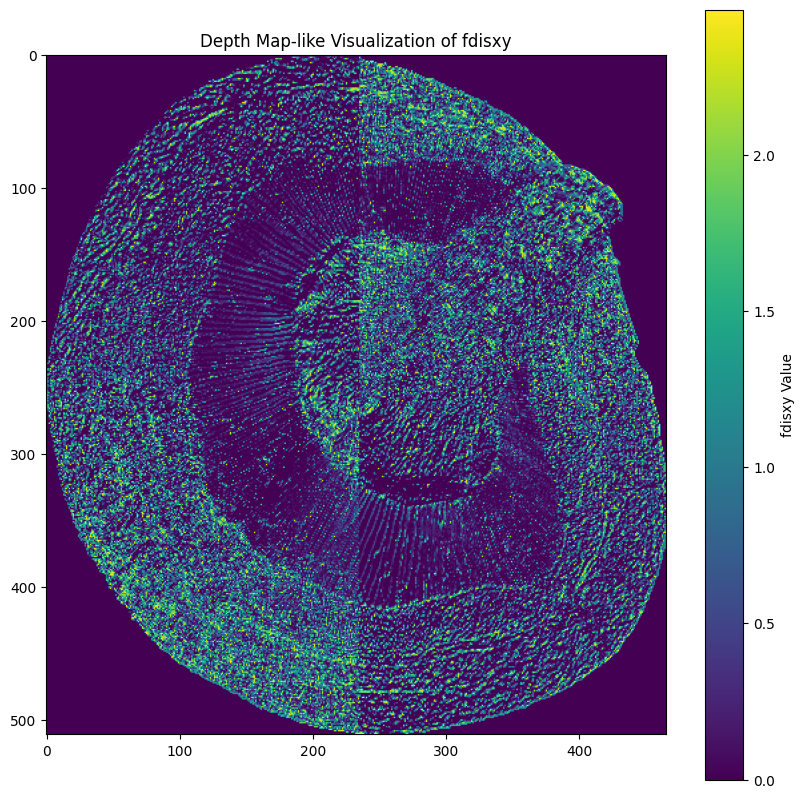

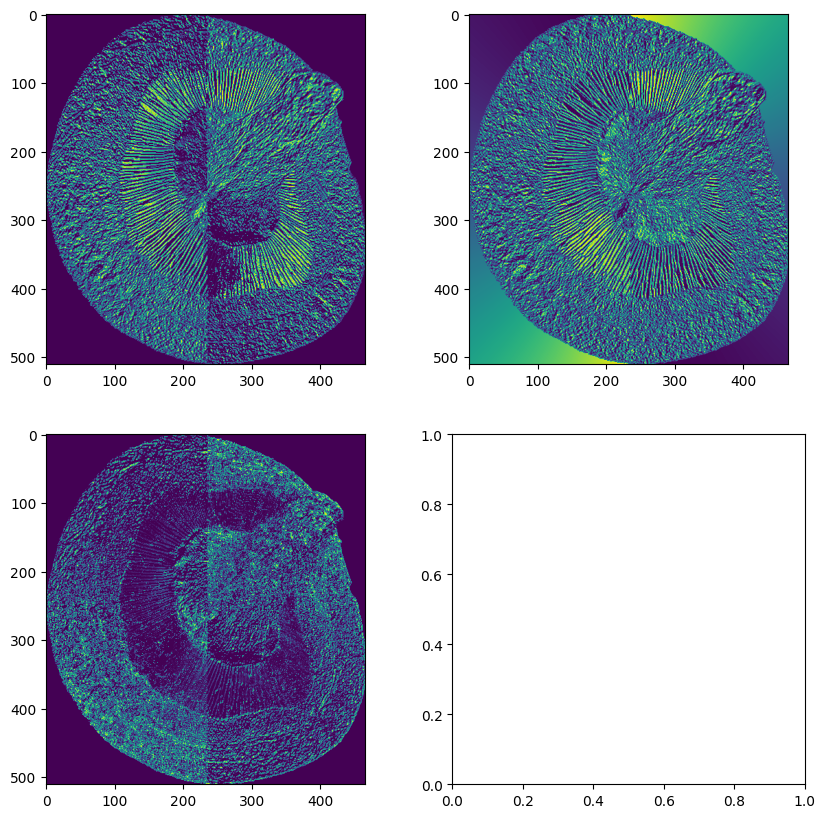

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

In [12]:
#f(xy)の勾配ベクトルが中心から(x,y)へのベクトルへ垂直か評価する関数fdisxy(4)(5)
# fdisxy = Min(G12(C0xy+np.pi/2, f0xy**2), G12(C0xy-np.pi/2, f0xy**2))
fdisxy = Min(G12(C0xy+np.pi/2, f0xy)**2, G12(C0xy-np.pi/2, f0xy)**2)
# fdisxy_t_1 = Min(G12(C0xy, tmp_f0xy+np.pi/2)**2, G12(C0xy, tmp_f0xy-np.pi/2)**2)
# fdisxy = Min(G12(C0xy+np.pi/2, f0xy), G12(C0xy-np.pi/2, f0xy))
fdisxy_0 = G12(C0xy+np.pi/2, f0xy)**2
fdisxy_1 = G12(C0xy-np.pi/2, f0xy)**2
# fdisxy = np.minimum(np.abs(C0xy+np.pi/2 - f0xy), np.abs(C0xy-np.pi/2 - f0xy)
# fdisxy = np.nan_to_num(fdisxy, nan=0.0)

# 深度マップとして表示
plt.figure(figsize=(10, 10))
plt.imshow(fdisxy, cmap='viridis')
plt.colorbar(label='fdisxy Value')
plt.title('Depth Map-like Visualization of fdisxy')
plt.show()
np.set_printoptions(threshold=np.inf)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(fdisxy_0, cmap='viridis')
axes[0, 1].imshow(fdisxy_1, cmap='viridis')
axes[1, 0].imshow(fdisxy, cmap='viridis')
# axes[1, 1].imshow(fdisxy2, cmap='viridis')
plt.show()
print((fdisxy))

In [56]:
#fmxy (7)
def fmxy(absfxy, mxy):
    return np.where(absfxy > mxy, 1, 0)

In [57]:
#mxy, mxy=|fxy|に対する2n+1×2n+1のメディアンフィルタリングの結果
n = 15
kernel_size = 2 * n + 1
# absfxy8 = np.uint8(absfxy)
mxy = np.uint8(cv2.medianBlur(absfxy, kernel_size))

# plt.imshow(absfxy, cmap='gray')
# plt.imshow(mxy, cmap='gray')

In [58]:
#rdis (8)
rdisxy = fmxy(absfxy,mxy) * fdisxy

In [59]:
#Iruv rdisxyの積分画像(9)
Iruv = cv2.integral(rdisxy)
# print(len(Iruv))

In [60]:
#Imyv fmxyの積分画像(10)
Imyv = cv2.integral(fmxy(absfxy,mxy).astype(np.uint8))

In [61]:
#平方面積の合計(11)(12) Tr Tm
def SquareSum(I, x, y, h, w, n):
    x1 , y1 = x - n, y - n
    x2 , y2 = x + n, y + n
    x1, x2 = max(x1, 0), min(x2, w - 2)
    y1, y2 = max(y1, 0), min(y2, h - 2)
    total = I[y2, x2] - I[y1, x2] - I[y2, x1] + I[y1, x1]
    return total

In [62]:
# h, w = masked_img.shape[:2]
# ic(SquareSum(Iruv, 150, 150, h, w, 3))
# ic(SquareSum(Imyv, 150, 150, h, w, 3))
# ic(SquareSum(Iruv, 150, 150, h, w, 3) / SquareSum(Imyv, 150, 150, h, w, 3))

In [63]:
#sdis = Tr/Tm (13)
def sdis(Iruv, Imyv, x, y, h, w, n):
    Tr = SquareSum(Iruv, x, y, h, w, n)
    Tm = SquareSum(Imyv, x, y, h, w, n)
    return Tr / Tm

In [64]:
n = 15
image = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
sdisval = np.zeros((image.shape[0], image.shape[1])) 
h, w = masked_img.shape[:2]
for y in range(0, image.shape[0], 1):
    for x in range(0, image.shape[1], 1):
        sdisval[y, x] = sdis(Iruv, Imyv, x, y, h, w, n)
sdisval = np.nan_to_num(sdisval, nan=0.0, posinf=0.0, neginf=0.0)
# plt.figure(figsize=(7, 7))
# plt.imshow(sdisval, cmap='viridis')
# plt.colorbar(label='sdis Value')
# plt.title('Depth Map-like Visualization of sdis')
# plt.show()
# np.set_printoptions(threshold=np.inf)


/tmp/ipykernel_745463/3533982195.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return Tr / Tm
/tmp/ipykernel_745463/3533982195.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return Tr / Tm


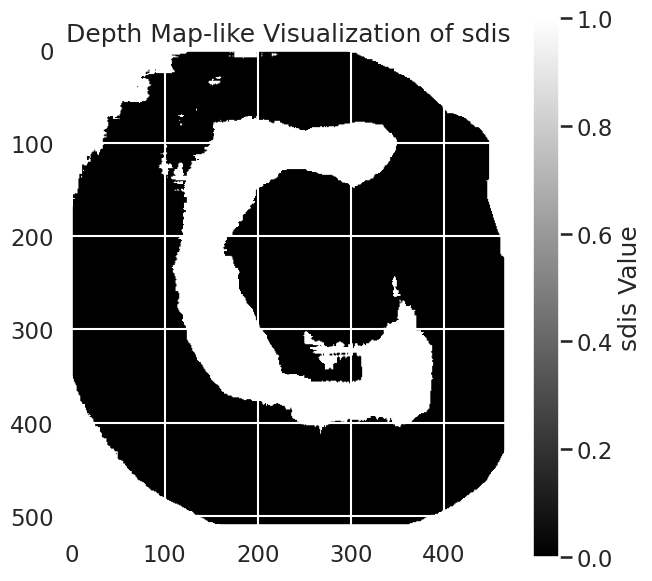

In [65]:
T = 0.25
hxy = sdisval.copy()
hxy[sdisval < T] = 1
hxy[sdisval >= T] = 0
plt.figure(figsize=(7, 7))
plt.imshow(hxy, cmap='gray')
plt.colorbar(label='sdis Value')
plt.title('Depth Map-like Visualization of sdis')
plt.show()

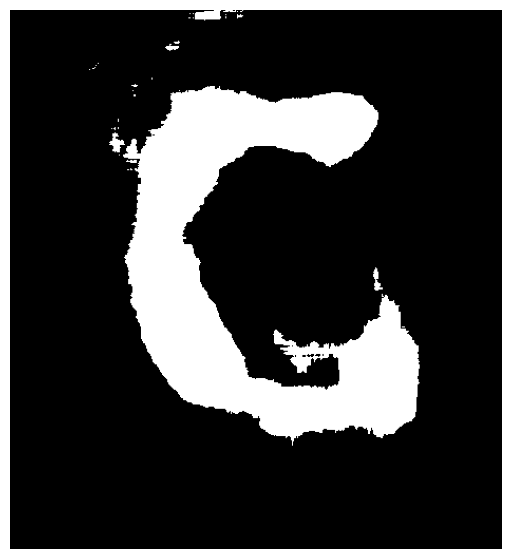

In [66]:
hxy2 = cv2.bitwise_and(hxy,hxy,mask=mask_img)
plt.figure(figsize=(7, 7))
plt.imshow(hxy2, cmap='gray')
plt.axis('off')
# 余白を削除して保存
plt.savefig('output.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [67]:
#シイタケ領域のPixel数を計算
count_mask = np.sum(mask_img == 255)
# print(count_255)
count_hida = np.sum(hxy2 == 1)
# print(count_hida)
R = count_hida / count_mask
print(R)

0.22215378682791237


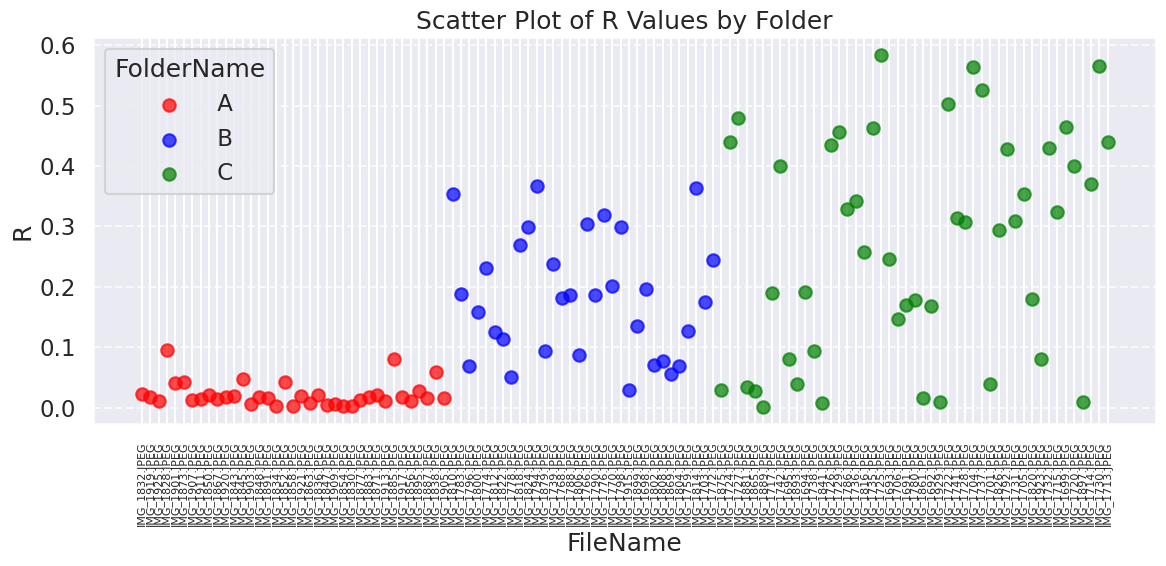

In [68]:
#hida_report_rev.pyの可視化
import matplotlib.pyplot as plt
import pandas as pd

# ファイルパス
input_file = "/home/data/0107_jikunashi_change/R_values.txt"

# データを読み込む
data = pd.read_csv(input_file, skiprows=1, names=["FileName", "FolderName", "R"])

# フォルダごとの色を指定
colors = {" A": "red", " B": "blue", " C": "green"}

# 散布図を描画
plt.figure(figsize=(12, 6))
for folder in data["FolderName"].unique():
    folder_data = data[data["FolderName"] == folder]
    plt.scatter(folder_data["FileName"], folder_data["R"], label=folder, color=colors[folder], alpha=0.7)

# グラフの装飾
plt.xlabel("FileName")
plt.ylabel("R")
plt.title("Scatter Plot of R Values by Folder")
plt.xticks(rotation=90, fontsize=8)  # ファイル名を見やすくするために回転
plt.legend(title="FolderName")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# グラフを表示
plt.show()


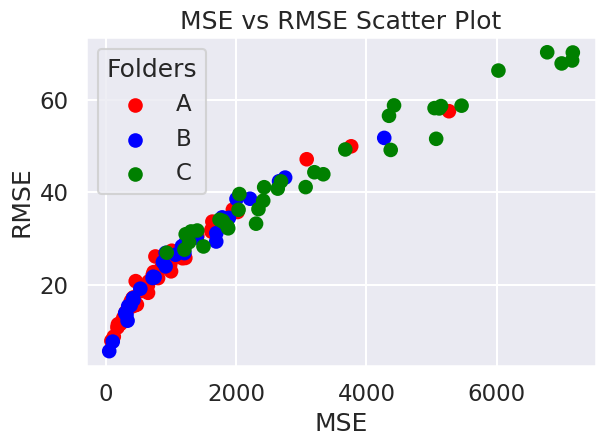

In [69]:
from sklearn.metrics import r2_score
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error

data = "0108_jikunashi_energee"
# データフォルダのパスリスト
folders = [
   f"/home/data/{data}/maskBB/A",
   f"/home/data/{data}/maskBB/B",
   f"/home/data/{data}/maskBB/C"
]

# 1次元データを保存する辞書と評価結果を格納する辞書
one_dimensional_data_dict = {}
evaluation_results = {}
folder_colors = {"A": "red", "B": "blue", "C": "green"}

# フォルダごとに処理
for folder in folders:
    folder_name = os.path.basename(folder)
    image_paths = glob.glob(os.path.join(folder, '*.JPEG'))

    for img_path in image_paths:
        # 画像の読み込み
        mask = cv2.imread(img_path)

        # グレースケール画像に変換
        gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # 二値化
        _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # 輪郭を検出し、最大の輪郭を取得
        contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        max_contour = max(contours, key=cv2.contourArea)

        # 最小外接円を取得
        (x, y), radius = cv2.minEnclosingCircle(max_contour)
        radius = int(radius)

        # 重心を計算
        M = cv2.moments(max_contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
        center = (cX, cY)

        # 極座標変換
        h, w = gray.shape
        flags = cv2.INTER_CUBIC + cv2.WARP_FILL_OUTLIERS + cv2.WARP_POLAR_LINEAR
        linear_polar = cv2.warpPolar(gray, (w, h), center, radius, flags)

        # 行ごとの黒ピクセル数をカウント
        black_pixel_count = np.sum(linear_polar == 0, axis=1)
        file_name = os.path.basename(img_path)
        one_dimensional_data_dict[file_name] = black_pixel_count

        # 真円の場合の理想データ（黒ピクセル数が0）
        y_pseudo = np.zeros_like(black_pixel_count)

        # 評価指標の計算
        mae = mean_absolute_error(y_pseudo, black_pixel_count)
        mse = mean_squared_error(y_pseudo, black_pixel_count)
        r2 = r2_score(y_pseudo, black_pixel_count)

        evaluation_results[file_name] = {
            'MSE': mse, 
            'MAE': mae, 
            'R²': r2,
            'Folder': folder_name
        }

# 散布図の作成
file_names = list(evaluation_results.keys())
mae_values = [metrics['MAE'] for metrics in evaluation_results.values()]
mse_values = [metrics['MSE'] for metrics in evaluation_results.values()]
rmse_values = [np.sqrt(metrics['MSE']) for metrics in evaluation_results.values()]
r2_values = [metrics['R²'] for metrics in evaluation_results.values()]
colors = [folder_colors[metrics['Folder']] for metrics in evaluation_results.values()]

# 散布図のプロット
# plt.figure(figsize=(12, 6))

# MSE vs RMSE
scatter1 = plt.scatter(mse_values, mae_values, c=colors)
for folder, color in folder_colors.items():
    plt.scatter([], [], c=color, label=folder)
plt.legend(title="Folders")
plt.xlabel('MSE')
plt.ylabel('RMSE')
plt.title('MSE vs RMSE Scatter Plot')

# グラフの表示
plt.tight_layout()
plt.show()


/tmp/ipykernel_745463/4030828375.py:25: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_745463/4030828375.py:25: UserWarning: Glyph 32026 (\N{CJK UNIFIED IDEOGRAPH-7D1A}) missing from current font.
  plt.tight_layout()
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32026 (\N{CJK UNIFIED IDEOGRAPH-7D1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


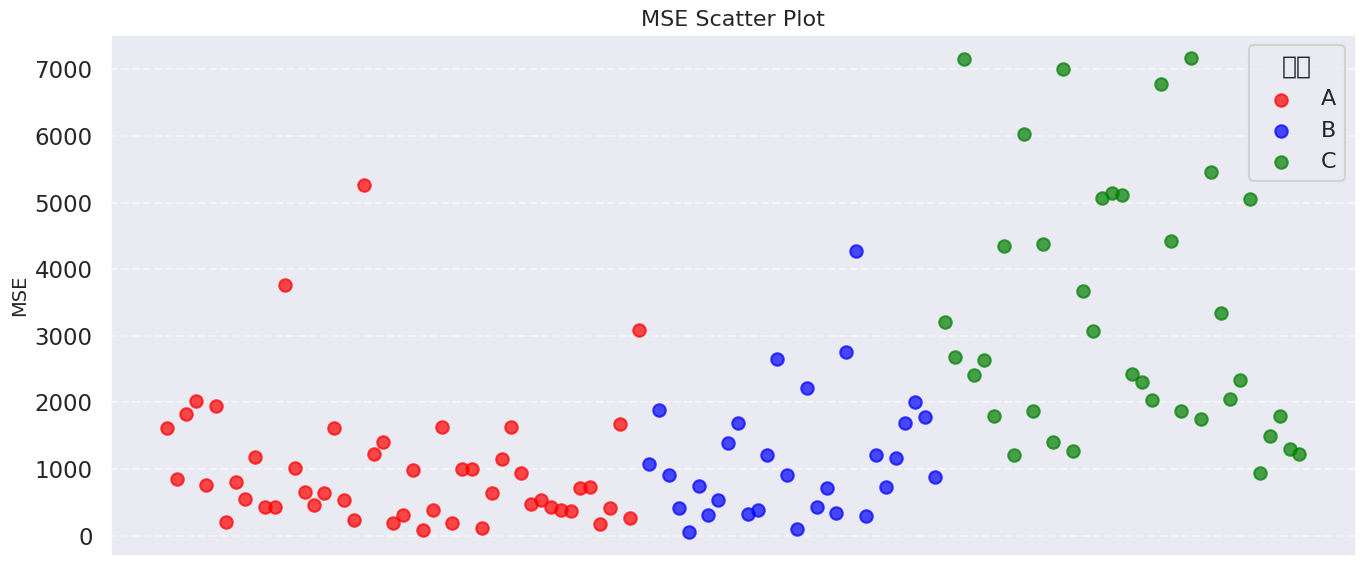

In [70]:
plt.figure(figsize=(14, 6))

# 散布図をプロット（フォルダごとに色分け）
for folder, color in folder_colors.items():
    # 該当フォルダのデータを抽出
    folder_files = [name for name, metrics in evaluation_results.items() if metrics['Folder'] == folder]
    folder_mse = [evaluation_results[name]['MSE'] for name in folder_files]
    
    # 該当フォルダの散布図を描画
    plt.scatter(folder_files, folder_mse, label=folder, color=color, alpha=0.7)

# 軸ラベルとタイトル
plt.xlabel('')
plt.ylabel('MSE', fontsize=14)
plt.title('MSE Scatter Plot', fontsize=16)

# x軸の目盛りラベルを非表示
plt.xticks([], [])

# 凡例とグリッド
plt.legend(title="等級", fontsize=16)
plt.grid(linestyle='--', alpha=0.5)

# レイアウト調整と表示
plt.tight_layout()
plt.show()


/tmp/ipykernel_745463/683988383.py:62: UserWarning: Glyph 35166 (\N{CJK UNIFIED IDEOGRAPH-895E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_745463/683988383.py:62: UserWarning: Glyph 38936 (\N{CJK UNIFIED IDEOGRAPH-9818}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_745463/683988383.py:62: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from current font.
  plt.tight_layout()
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35166 (\N{CJK UNIFIED IDEOGRAPH-895E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38936 (\N{CJK UNIFIED IDEOGRAPH-9818}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from current font.
  fi

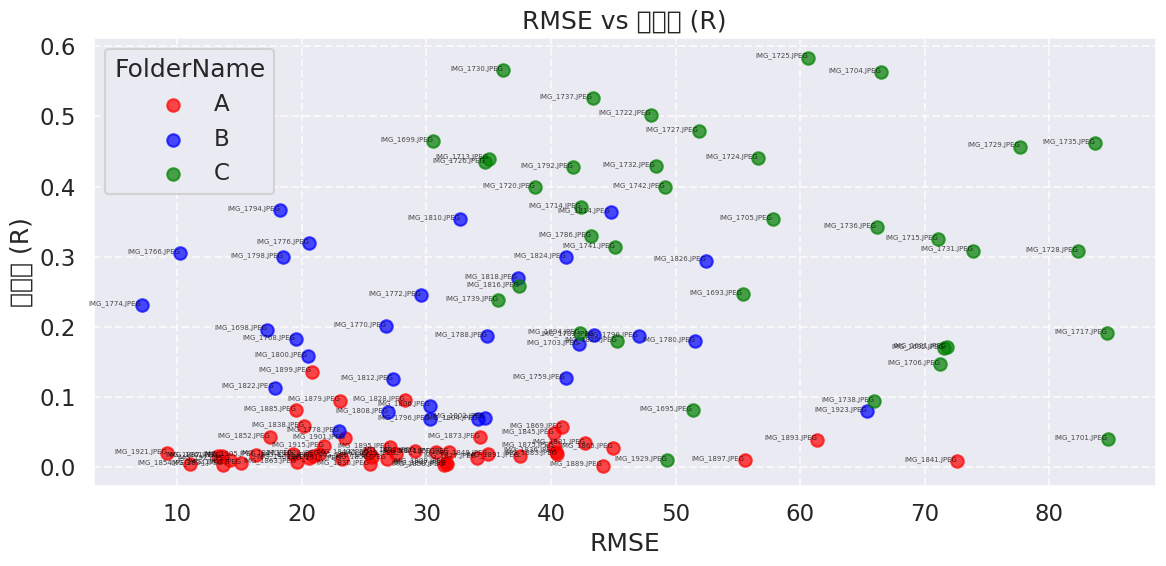

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import japanize_matplotlib

data = "0108_jikunashi_energee"

# 評価結果からRMSEを取得
evaluation_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
evaluation_df["FileName"] = evaluation_df.index
evaluation_df["RMSE"] = np.sqrt(evaluation_df["MSE"])
evaluation_df["MAE"] = evaluation_df["MAE"]
evaluation_df["MSE"] = evaluation_df["MSE"]

# R値データの読み込み
r_values_file = f"/home/data/{data}/R_values.txt"
r_values_df = pd.read_csv(r_values_file, skiprows=1, names=["FileName", "FolderName", "R"])

# ファイル名を揃える（必要に応じて）
r_values_df["FileName"] = r_values_df["FileName"].str.strip()

# データフレームをマージ
merged_df = pd.merge(evaluation_df, r_values_df, on="FileName")

# フォルダごとの色指定
folder_colors = {"A": "red", "B": "blue", "C": "green"}
merged_df["Color"] = merged_df["FolderName"].map(folder_colors)

# グラフの作成
# グラフの作成
plt.figure(figsize=(12, 6))

for folder in merged_df["FolderName"].unique():
    folder_data = merged_df[merged_df["FolderName"] == folder]
    
    # 各データポイントをプロット
    plt.scatter(
        folder_data["RMSE"], 
        folder_data["R"], 
        label=folder.strip(), 
        color=folder_colors[folder.strip()], 
        alpha=0.7
    )
    # 各データポイントにファイル名を表示
    for i, row in folder_data.iterrows():
        plt.text(
            row["RMSE"], 
            row["R"], 
            row["FileName"], 
            fontsize=5, 
            ha='right', 
            color='black', 
            alpha=0.7
        )
    
# グラフの装飾
plt.xlabel("RMSE")
plt.ylabel("襞領域 (R)")
plt.title("RMSE vs 襞領域 (R)")
plt.legend(title="FolderName")
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.tight_layout()

# グラフを表示
plt.show()



/tmp/ipykernel_745463/3315680308.py:28: UserWarning: Glyph 35166 (\N{CJK UNIFIED IDEOGRAPH-895E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_745463/3315680308.py:28: UserWarning: Glyph 38936 (\N{CJK UNIFIED IDEOGRAPH-9818}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_745463/3315680308.py:28: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_745463/3315680308.py:28: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_745463/3315680308.py:28: UserWarning: Glyph 32026 (\N{CJK UNIFIED IDEOGRAPH-7D1A}) missing from current font.
  plt.tight_layout()


/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35166 (\N{CJK UNIFIED IDEOGRAPH-895E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38936 (\N{CJK UNIFIED IDEOGRAPH-9818}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32026 (\N{CJK UNIFIED IDEOGRAPH-7D1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

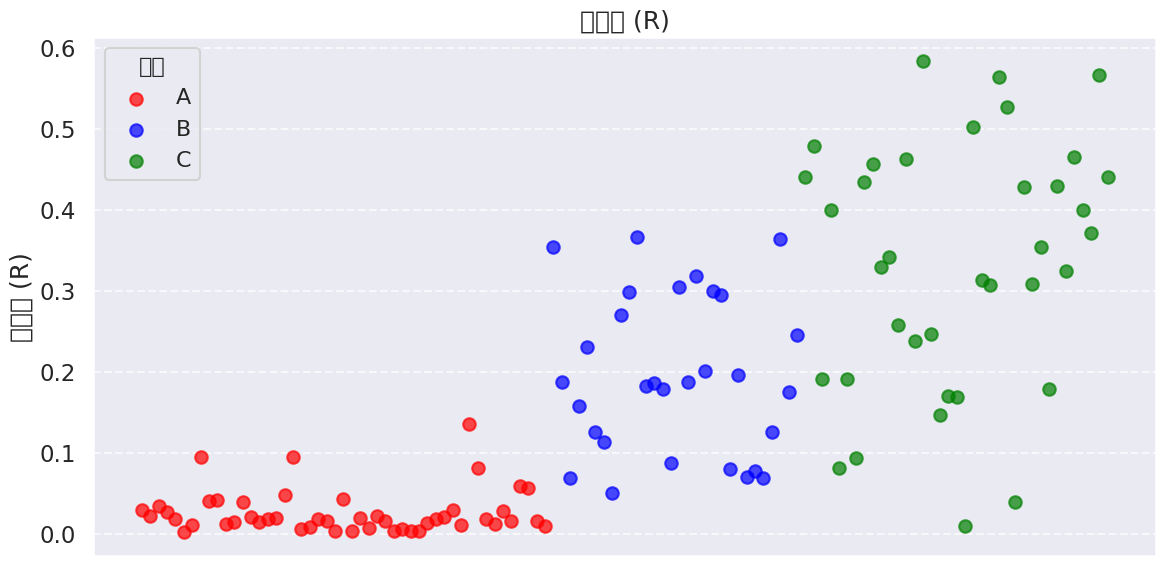

In [72]:
# x軸をファイル名のインデックスに設定
merged_df["FileIndex"] = range(len(merged_df))

# グラフの作成
plt.figure(figsize=(12, 6))

for folder in merged_df["FolderName"].unique():
    folder_data = merged_df[merged_df["FolderName"] == folder]
    
    # 各データポイントをプロット
    plt.scatter(
        folder_data["FileIndex"], 
        folder_data["R"], 
        label=folder.strip(), 
        color=folder_colors[folder.strip()], 
        alpha=0.7
    )

# x軸ラベルを非表示に設定
plt.xticks([], [])

# グラフの装飾
# plt.xlabel("File Index")  # インデックスとして説明を追加
plt.ylabel("襞領域 (R)")
plt.title("襞領域 (R)")
plt.legend(title="等級", fontsize=16, title_fontsize=16)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.tight_layout()

# グラフを表示
plt.show()


FolderNameごとのファイル数:
FolderName
A    49
B    30
C    28
Name: count, dtype: int64


/tmp/ipykernel_745463/1291781379.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="FolderName", y="R", data=data, palette="Set2")


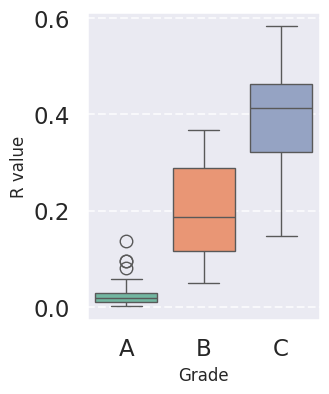

Folder Aの分散: 0.0007307556406632651
Folder Bの分散: 0.009556016460874714
Folder Cの分散: 0.012526006810406084
AとB間のT検定結果 - t-statistic: -9.248512914739294, p-value: 1.600246919638216e-10
AとB間には有意な差があります
BとC間のT検定結果 - t-statistic: -7.224984125091217, p-value: 1.470071645357795e-09
BとC間には有意な差があります
AとC間のT検定結果 - t-statistic: -17.11080763327994, p-value: 1.2408345679192045e-16
AとC間には有意な差があります


In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# データの読み込み
data = "0108_hida"
file_path = f"/home/data/{data}/R_values.txt"  # 実際のファイル名を指定
data = pd.read_csv(file_path, delimiter=", ", engine="python")

# 各FolderNameごとのファイル数を表示
file_counts = data['FolderName'].value_counts()
print(f"FolderNameごとのファイル数:\n{file_counts}")

# 箱ひげ図の作成
# plt.figure(facecolor='white')
plt.figure(figsize=(3, 4))
sns.boxplot(x="FolderName", y="R", data=data, palette="Set2")
# plt.title("Boxplot of R values by FolderName", fontsize=14)
plt.xlabel("Grade", fontsize=12)
plt.ylabel("R value", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 各グループのデータ
group_a = data[data['FolderName'] == 'A']['R']
group_b = data[data['FolderName'] == 'B']['R']
group_c = data[data['FolderName'] == 'C']['R']

# 各グループの分散計算
var_a = np.var(group_a, ddof=1)  # 不偏分散を計算（ddof=1）
var_b = np.var(group_b, ddof=1)
var_c = np.var(group_c, ddof=1)

# 分散の表示
print(f"Folder Aの分散: {var_a}")
print(f"Folder Bの分散: {var_b}")
print(f"Folder Cの分散: {var_c}")

# A, B間のT検定
t_stat_ab, p_value_ab = ttest_ind(group_a, group_b,equal_var=False)
print(f"AとB間のT検定結果 - t-statistic: {t_stat_ab}, p-value: {p_value_ab}")
if p_value_ab < 0.05:
    print("AとB間には有意な差があります")
else:
    print("AとB間には有意な差はありません")

# B, C間のT検定
t_stat_bc, p_value_bc = ttest_ind(group_b, group_c)#分散の有意差なし
print(f"BとC間のT検定結果 - t-statistic: {t_stat_bc}, p-value: {p_value_bc}")
if p_value_bc < 0.05:
    print("BとC間には有意な差があります")
else:
    print("BとC間には有意な差はありません")

# A, C間のT検定
t_stat_ac, p_value_ac = ttest_ind(group_a, group_c,equal_var=False)
print(f"AとC間のT検定結果 - t-statistic: {t_stat_ac}, p-value: {p_value_ac}")
if p_value_ac < 0.05:
    print("AとC間には有意な差があります")
else:
    print("AとC間には有意な差はありません")

In [74]:
from scipy.stats import levene

# A, B, C間の分散が等しいかを検定
stat, p_value = levene(group_b, group_c)
print(f"Levene検定結果 - statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("分散に有意な差があります")
else:
    print("分散に有意な差はありません")


Levene検定結果 - statistic: 0.4203254318964508, p-value: 0.5194243759660511
分散に有意な差はありません


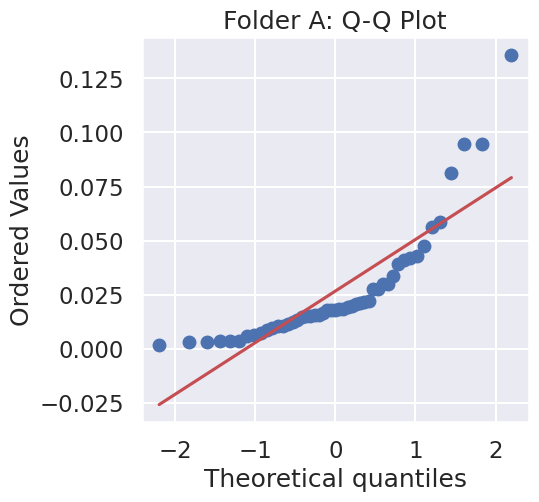

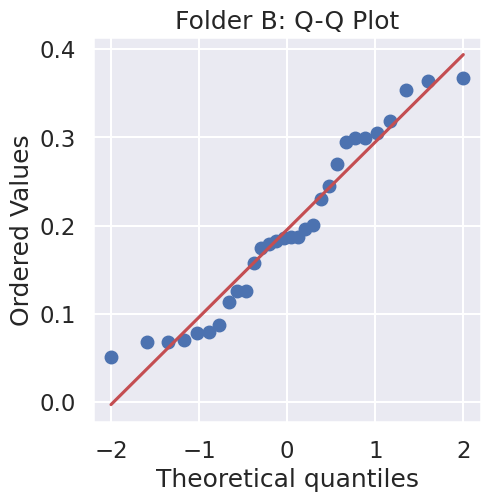

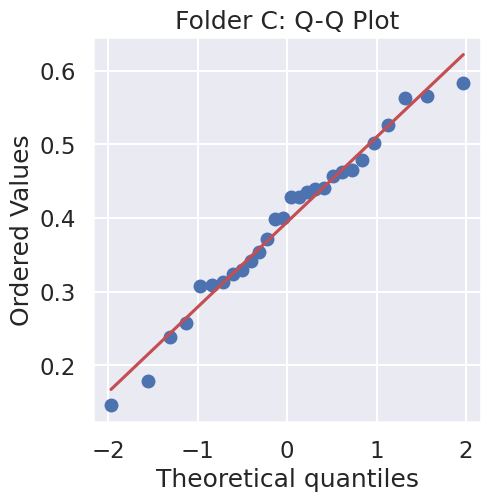

In [75]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# 日本語フォントを設定（Matplotlib）
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

# データの読み込み
data = "0108_hida"
file_path = f"/home/data/{data}/R_values.txt"  # 実際のファイル名を指定
data = pd.read_csv(file_path, delimiter=", ", engine="python")

# データの分割
df_A = data[data["FolderName"] == "A"]
df_B = data[data["FolderName"] == "B"]
df_C = data[data["FolderName"] == "C"]

# Seabornの設定
sns.set(context="talk")

# Folder Aの正規性確認：Q-Qプロット
plt.figure(figsize=(5, 5))
stats.probplot(df_A["R"], dist="norm", plot=plt)
plt.title("Folder A: Q-Q Plot")
plt.show()

# Folder Bの正規性確認：Q-Qプロット
plt.figure(figsize=(5,5 ))
stats.probplot(df_B["R"], dist="norm", plot=plt)
plt.title("Folder B: Q-Q Plot")
plt.show()

# Folder Cの正規性確認：Q-Qプロット
plt.figure(figsize=(5, 5))
stats.probplot(df_C["R"], dist="norm", plot=plt)
plt.title("Folder C: Q-Q Plot")
plt.show()


/tmp/ipykernel_745463/3549046130.py:63: UserWarning: Glyph 35166 (\N{CJK UNIFIED IDEOGRAPH-895E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_745463/3549046130.py:63: UserWarning: Glyph 38936 (\N{CJK UNIFIED IDEOGRAPH-9818}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_745463/3549046130.py:63: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from current font.
  plt.tight_layout()
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35166 (\N{CJK UNIFIED IDEOGRAPH-895E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38936 (\N{CJK UNIFIED IDEOGRAPH-9818}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from current font.
 

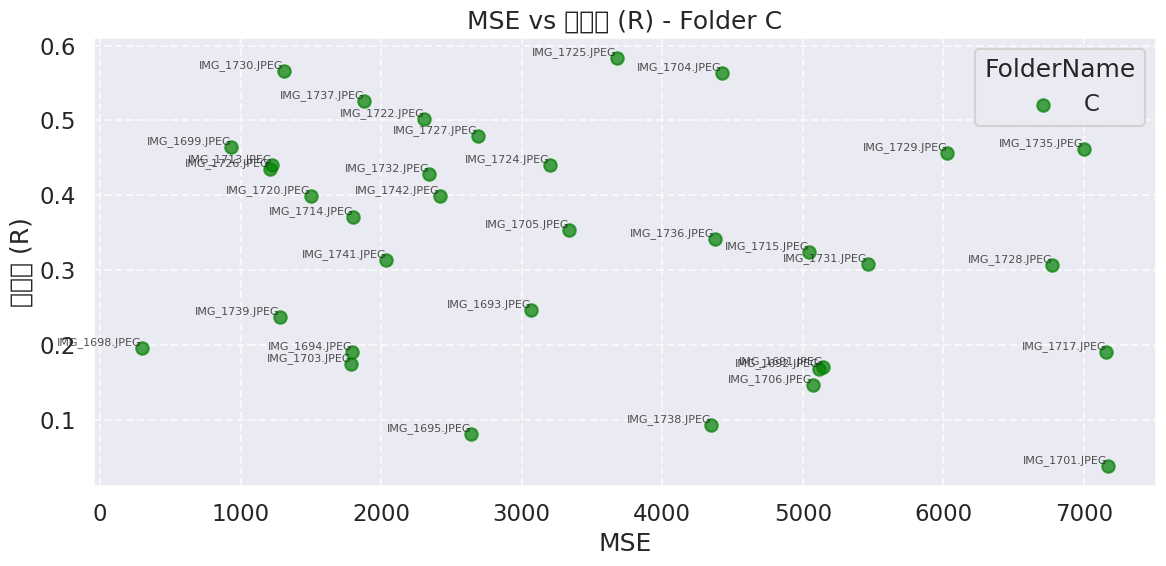

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import japanize_matplotlib

# 評価結果からRMSEを取得
evaluation_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
evaluation_df["FileName"] = evaluation_df.index
evaluation_df["RMSE"] = np.sqrt(evaluation_df["MSE"])

# R値データの読み込み
r_values_file = "/home/data/1216_jikunashi/R_values.txt"
r_values_df = pd.read_csv(r_values_file, skiprows=1, names=["FileName", "FolderName", "R"])

# ファイル名とフォルダ名の空白を削除
r_values_df["FileName"] = r_values_df["FileName"].str.strip()
r_values_df["FolderName"] = r_values_df["FolderName"].str.strip()

# データフレームをマージ
merged_df = pd.merge(evaluation_df, r_values_df, on="FileName")

# フォルダ "C" のデータのみをフィルタリング
folder_name = "C"
filtered_df = merged_df[merged_df["FolderName"] == folder_name]

# データの確認
# print("Filtered DataFrame (Folder C):")
# print(filtered_df)

# フォルダごとの色指定
folder_colors = {"A": "red", "B": "red", "C": "green"}

# グラフの作成
plt.figure(figsize=(12, 6))

# フォルダ "C" のデータをプロット
if not filtered_df.empty:  # データが存在する場合のみ描画
    plt.scatter(
        filtered_df["MSE"], 
        filtered_df["R"], 
        label=folder_name, 
        color=folder_colors[folder_name], 
        alpha=0.7
    )

    # 各点にファイル名を表示
    for _, row in filtered_df.iterrows():
        plt.text(
            row["MSE"], row["R"], 
            row["FileName"],  # 表示するファイル名
            fontsize=8,       # フォントサイズ
            ha='right',       # 水平方向の配置
            va='bottom',      # 垂直方向の配置
            alpha=0.8         # 透明度（オプション）
        )

# グラフの装飾
plt.xlabel("MSE")
plt.ylabel("襞領域 (R)")
plt.title(f"MSE vs 襞領域 (R) - Folder {folder_name}")
plt.legend(title="FolderName")
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.tight_layout()

# グラフを表示
plt.show()


In [77]:
# from PIL import Image

# # 画像を読み込む
# image = Image.open("/home/data/1008/crop/IMG_0000.png")
# image2 = Image.open("/home/data/1008/crop/IMG_0000.png")
# # 新しい解像度を指定 (例: 幅と高さを50%に縮小)
# scale = 0.5
# new_width = int(image.width * scale)
# new_height = int(image.height * scale)

# # 解像度を変更
# resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

# # 結果を保存または表示
# resized_image.save("/home/data/1008/crop/resized_image.png")
# # resized_image.show()
# print(image.size)
# print(resized_image.size)


In [78]:
# #(9~13),rdisxyの平滑化
# n = 5
# sdis = cv2.blur(rdisxy, (2*n+1, 2*n+1))
# plt.figure(figsize=(7, 7))
# plt.imshow(sdis, cmap='viridis')
# plt.colorbar(label='fdisxy Value')
# plt.title('Depth Map-like Visualization of fdisxy')
# plt.show()
# np.set_printoptions(threshold=np.inf)


In [2]:
#計測
import os
import re
import cv2
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from icecream import ic
import time

start = time.perf_counter()

# fmxy (7)
def fmxy(absfxy, mxy):
    return np.where(absfxy > mxy, 1, 0)

def Min(a, b):
    return np.minimum(a, b)

def G12(theta1, theta2):
    condition1 = (theta2 - np.pi < theta1) & (theta1 < theta2) & (theta2 >= 0)
    result1 = np.abs(theta1 - theta2)
    condition2 = (-np.pi < theta1) & (theta1 < (theta2 - np.pi)) & (theta2 >= 0)
    result2 = theta2 - 2 * np.pi - theta1
    condition3 = (-np.pi < theta1) & (theta1 < (theta2 + np.pi)) & (theta2 < 0)
    result3 = np.abs(theta1 - theta2)
    condition4 = (theta2 + np.pi < theta1) & (theta1 < np.pi) & (theta2 < 0)
    result4 = theta1 - theta2 - 2 * np.pi
    result = np.where(condition1, result1, 
             np.where(condition2, result2, 
             np.where(condition3, result3, 
             np.where(condition4, result4, 0))))
    return result

# 平方面積の合計 (11)(12) Tr Tm
def SquareSum(I, x, y, h, w, n):
    x1, y1 = x - n, y - n
    x2, y2 = x + n, y + n
    x1, x2 = max(x1, 0), min(x2, w - 2)
    y1, y2 = max(y1, 0), min(y2, h - 2)
    total = I[y2, x2] - I[y1, x2] - I[y2, x1] + I[y1, x1]
    return total

# sdis = Tr/Tm (13)
def sdis(Iruv, Imyv, x, y, h, w, n):
    Tr = SquareSum(Iruv, x, y, h, w, n)
    Tm = SquareSum(Imyv, x, y, h, w, n)
    return Tr / Tm

# パラメータ
n = 15
date = "0203_energee_after"
output_file = f"/home/data/{date}/R_values.txt"

img_folders = [
    f"/home/data/{date}/maskedBB/A",
    f"/home/data/{date}/maskedBB/B",
    f"/home/data/{date}/maskedBB/C",
]
mask_folders = [
    f"/home/data/{date}/maskBB/A",
    f"/home/data/{date}/maskBB/B",
    f"/home/data/{date}/maskBB/C",
]

for img_folder, mask_folder in zip(img_folders, mask_folders):
    folder_name = os.path.basename(img_folder)
    img_files = os.listdir(img_folder)
    mask_files = os.listdir(mask_folder)
    
    for img_file, mask_file in zip(img_files, mask_files):
        img_path = os.path.join(img_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)
        
        # 重心 (1)
        img = cv2.imread(img_path)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        masked_img = cv2.imread(img_path)
        h, w = img.shape[:2]
        
        # 重心を計算
        x_sum, y_sum, count = 0, 0, 0
        for i in range(h):
            for j in range(w):
                if mask_img[i][j] == 255:
                    x_sum += j
                    y_sum += i
                    count += 1
        xc, yc = (x_sum / count, y_sum / count) if count > 0 else (0, 0)
        
        # fθ(x,y)(勾配の方向), |f(x,y)| (2)(3)
        image = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
        fdy, fdx = np.gradient(image)
        f0xy = np.arctan2(fdy, fdx)
        absfxy = np.uint8(np.sqrt(fdx**2 + fdy**2))
        
        # C0(x,y)：中心からのベクトルの角度
        height, width = image.shape
        C0xy = np.zeros((height, width))
        for y in range(height):
            for x in range(width):
                dx, dy = x - xc, y - yc
                C0xy[y, x] = np.arctan(dy / dx) if dx != 0 else 0
        
        # f(xy)の勾配ベクトルが中心から(x,y)へのベクトルへ垂直か評価する関数fdisxy(4)(5)
        fdisxy = Min(G12(C0xy + np.pi/2, f0xy)**2, G12(C0xy - np.pi/2, f0xy)**2)
        
        # mxy = |fxy|に対する2n+1×2n+1のメディアンフィルタリングの結果
        kernel_size = 2 * n + 1
        mxy = np.uint8(cv2.medianBlur(absfxy, kernel_size))
        
        # rdis (8)
        rdisxy = fmxy(absfxy, mxy) * fdisxy
        
        # Iruv, Imyv (9)(10)
        Iruv = cv2.integral(rdisxy)
        Imyv = cv2.integral(fmxy(absfxy, mxy).astype(np.uint8))
        
        # sdis計算
        sdisval = np.zeros((image.shape[0], image.shape[1]))
        for y in range(0, image.shape[0], 1):
            for x in range(0, image.shape[1], 1):
                sdisval[y, x] = sdis(Iruv, Imyv, x, y, h, w, n)
        sdisval = np.nan_to_num(sdisval, nan=0.0, posinf=0.0, neginf=0.0)
        
        # 閾値処理
        T = 0.2
        hxy = np.where(sdisval < T, 1, 0)
        hxy2 = cv2.bitwise_and(hxy, hxy, mask=mask_img)
        
        # シイタケ領域のPixel数を計算
        count_mask = np.sum(mask_img == 255)
        count_hida = np.sum(hxy2 == 1)
        R = count_hida / count_mask if count_mask > 0 else 0
end = time.perf_counter()
print(f"Runtime: {end - start:.6f} seconds")

/tmp/ipykernel_883034/548887919.py:49: RuntimeWarning: invalid value encountered in scalar divide
  return Tr / Tm
/tmp/ipykernel_883034/548887919.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  return Tr / Tm


Runtime: 82.315819 seconds
